<a href="https://colab.research.google.com/github/matthew-william-lock/Alzheimers-CNN/blob/main/AD_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Kaggle Dataset

# Load Libraries

In [5]:
import numpy as np

import os
import sys
from PIL import Image

# tensorflow
import tensorflow as tf

# sklearn
from sklearn.model_selection import train_test_split

# Plotting
from matplotlib import pyplot as plt

# Augmentation
import imgaug as ia
from imgaug import augmenters as iaa


In [6]:
# Follow tutorial at : https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/

! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download sachinkumar413/alzheimer-mri-dataset
! unzip alzheimer-mri-dataset.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
alzheimer-mri-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  alzheimer-mri-dataset.zip
replace Dataset/Mild_Demented/mild.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# Check if GPU is Avaiable

Useful links:
- [Enabling GPUs for google collab](https://colab.research.google.com/notebooks/gpu.ipynb)

In [7]:
device_name = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


# Load Data

In [8]:
# Load and process data

cwd = os.path.join(os.getcwd(), 'Dataset')


def data_processing():

    # Define labes
    c = ['mild','moderate','non','verymild']

    # Define map for number of images
    image_breakdown = {}
    for key in c:
      image_breakdown[key] = 0   

    # Get list of directories in 'Dataset' folder 
    pic_directories = os.listdir(cwd)

    # Instantiate X and Y
    X = []
    Y = []

    # Iterate through each directory
    for folder in pic_directories:

      # Get images in folder
      print(folder)
      dir = os.path.join(cwd, str(folder))
      images = os.listdir(dir)
      print(len(images))

      # Iterate through images and add to data
      for image_str in images:
        image_name = image_str.split('.')[0]
        with Image.open(os.path.join(dir,image_str)) as im:    
          key = image_name.split('_')[0]
          if len(X) == 0:
            X = [np.array(im)]
            Y = np.array([c.index(key)])
            image_breakdown[key] +=1
          else:
            X = np.append(X, [np.array(im)], axis=0)
            Y = np.append(Y, [c.index(key)],axis=0)
            image_breakdown[key] +=1
    
    # Process loaded data
    Y = tf.keras.utils.to_categorical(Y)
    X = X.astype('float32')
    X = X/np.max(X)     

    # return X, Y
    return X,Y, image_breakdown

X, Y, image_breakdown = data_processing()
print(image_breakdown)

Very_Mild_Demented
2240
Non_Demented
3200
Mild_Demented
896
Moderate_Demented
64
{'mild': 896, 'moderate': 64, 'non': 3200, 'verymild': 2240}


In [9]:
# Sanity check
print(X.shape)
print(Y.shape)

print("Image data")
print(X[0])
print("Label data")
print(Y[0])

# Total number of images
total_images = 0
for key in image_breakdown:
  total_images += image_breakdown[key]
print('Total images : {}'.format(total_images))

(6400, 128, 128)
(6400, 4)
Image data
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Label data
[0. 0. 0. 1.]
Total images : 6400


## Split Data

In [10]:
# index to label
index_to_label = {
    0 :'mild',
    1: 'moderate',
    2 : 'non',
    3 : 'verymild'
}

# Get data distribution
def get_data_distribution(data, normalise= True):
  """ REturn the distribution of images in each class"""

  distribution = {}
  total_images = 0;

  for key in index_to_label.keys():
    key = index_to_label[key]
    distribution[key] = 0
  
  # Get total number of images in each category
  for item in data:
    index = np.where(item == 1)
    key = index_to_label[index[0][0]]
    if key in distribution:
      distribution[key] +=1
    total_images +=1

  # Get distribution of each category
  if normalise:
    for key in distribution.keys():
      distribution[key] = distribution[key]/total_images
  distribution['total_images'] = total_images

  # Print results
  print(distribution)

def split_data_into_classes(X,Y):
  x_data = {}
  y_data = {}

  for index,image in enumerate(X):

    label = Y[index]
    index = np.where(label == 1)
    key = index_to_label[index[0][0]]

    if key not in x_data:
      x_data[key] = [image]
      y_data[key] = [label]

    else:
      x_data[key].append(image)
      y_data[key].append(label)

  return x_data, y_data

# Define data split
def partition(X,Y,size=0.2):
    return train_test_split(X, Y, test_size=size, random_state=42, stratify = Y)

# Partition the data
X_train, X_test, Y_train, Y_test = partition(X,Y)
get_data_distribution(Y)
get_data_distribution(Y_train)

{'mild': 0.14, 'moderate': 0.01, 'non': 0.5, 'verymild': 0.35, 'total_images': 6400}
{'mild': 0.1400390625, 'moderate': 0.0099609375, 'non': 0.5, 'verymild': 0.35, 'total_images': 5120}


## Augment the data

In [11]:
# Distribution before augmentation
get_data_distribution(Y_train,normalise = False)

{'mild': 717, 'moderate': 51, 'non': 2560, 'verymild': 1792, 'total_images': 5120}


In [12]:
# Apply augmentation on X_train_split, Y_train_split
# Split the training data into respective classes
X_train_split, Y_train_split = split_data_into_classes(X_train,Y_train)

# Augmentation sequences
rotate_seq = iaa.Sequential([iaa.Affine(rotate=(-25, 25),)], random_order=True) # apply augmenters in random order
translate_seq = iaa.Sequential([iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},)], random_order=True) 
gamma_correct_seq = iaa.Sequential([iaa.GammaContrast((0.5, 2.0))], random_order=True) 
gaus_seq = iaa.Sequential([iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05)),], random_order=True) 
scaling_seq =  iaa.Sequential([iaa.Affine(scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},)], random_order=True)
affine_seq =  iaa.Sequential([iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    )], random_order=True)  

keys = ['mild','moderate','non','verymild']   

# Rotate
def apply_augmentation(X_train_split,Y_train_split, num_copies, key):

  copies_X = X_train_split[key]*num_copies
  copies_Y = Y_train_split[key]*num_copies*6

  images_rotated = rotate_seq(images=copies_X)
  images_translated = translate_seq(images=copies_X)
  images_gamma_corrected = gamma_correct_seq(images=copies_X)
  images_gaus = gaus_seq(images=copies_X)
  images_scaled = scaling_seq(images=copies_X)
  images_affine = affine_seq(images=copies_X)

  # Create output of augmented images

  augmented_X = images_rotated
  augmented_Y = np.array(copies_Y)

  augmented_X = np.append(augmented_X, images_translated, axis=0)
  augmented_X = np.append(augmented_X, images_gamma_corrected, axis=0)
  augmented_X = np.append(augmented_X, images_gaus, axis=0)
  augmented_X = np.append(augmented_X, images_scaled, axis=0)
  augmented_X = np.append(augmented_X, images_affine, axis=0)

  return augmented_X,augmented_Y

augmented_X,augmented_Y = apply_augmentation(X_train_split,Y_train_split, 40, 'moderate')
X_train = np.append(X_train,augmented_X,axis=0)
Y_train = np.append(Y_train,augmented_Y,axis=0)

augmented_X,augmented_Y = apply_augmentation(X_train_split,Y_train_split, 1, 'non')
X_train = np.append(X_train,augmented_X,axis=0)
Y_train = np.append(Y_train,augmented_Y,axis=0)

augmented_X,augmented_Y = apply_augmentation(X_train_split,Y_train_split, 1, 'verymild')
X_train = np.append(X_train,augmented_X,axis=0)
Y_train = np.append(Y_train,augmented_Y,axis=0)

augmented_X,augmented_Y = apply_augmentation(X_train_split,Y_train_split, 3, 'mild')
X_train = np.append(X_train,augmented_X,axis=0)
Y_train = np.append(Y_train,augmented_Y,axis=0)

# Print distribution
get_data_distribution(Y_train,normalise = False)

{'mild': 13623, 'moderate': 12291, 'non': 17920, 'verymild': 12544, 'total_images': 56378}


In [13]:
# Print distribution
get_data_distribution(Y_train,normalise = False)
get_data_distribution(Y_train)

{'mild': 13623, 'moderate': 12291, 'non': 17920, 'verymild': 12544, 'total_images': 56378}
{'mild': 0.24163680868423854, 'moderate': 0.21801057149952108, 'non': 0.3178544822448473, 'verymild': 0.22249813757139308, 'total_images': 56378}


In [14]:
print('Shape Y_train " {}'.format(Y_train.shape))
print('Shape X_test " {}'.format(X_test.shape))
print('Shape Y_test " {}'.format(Y_test.shape))

Shape Y_train " (56378, 4)
Shape X_test " (1280, 128, 128)
Shape Y_test " (1280, 4)


# Model

## Define the model

In [15]:
def basic_CNN_model(): 
    model=tf.keras.Sequential()
    model.add(tf.keras.layers.Reshape(target_shape=(128,128,1), input_shape=(128,128)))
    model.add(tf.keras.layers.Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(128, 128, 1), name='first_conv')) #strides=(2, 2),
    #model.add(tf.keras.layers.BatchNormalization())
    #model.add(tf.keras.layers.Conv2D(2, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(tf.keras.layers.Conv2D(2, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', name='mid_conv'))
    model.add(tf.keras.layers.Conv2D(1, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', name='last_conv'))
    #model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
    #model.add(tf.keras.layers.Dropout(0.2))
    #model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(128, 128, 1))) #strides=(2, 2),
    #model.add(tf.keras.layers.Conv2D(1, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    #model.add(tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(tf.keras.layers.Flatten())
    #model.add(tf.keras.layers.Dense(32, activation="relu"))
    model.add(tf.keras.layers.Dense(4, activation="softmax"))
    return model

## Compile the mode

In [16]:
model = basic_CNN_model()
model.compile(optimizer="Adam", loss=tf.keras.losses.CategoricalCrossentropy(), metrics=[tf.keras.metrics.CategoricalAccuracy()])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 128, 128, 1)       0         
                                                                 
 first_conv (Conv2D)         (None, 128, 128, 8)       80        
                                                                 
 mid_conv (Conv2D)           (None, 128, 128, 2)       146       
                                                                 
 last_conv (Conv2D)          (None, 128, 128, 1)       19        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 1)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 3969)              0         
                                                        

# Train the model

In [17]:
history = model.fit(X_train, Y_train, epochs=30, batch_size=64, validation_data=(X_test, Y_test), verbose=1, callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/30
 20/881 [..............................] - ETA: 11:40 - loss: 1.3952 - categorical_accuracy: 0.2984

KeyboardInterrupt: ignored

# Plot results

In [ ]:
def summarize_diagnostics(history, model_name):

    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='royalblue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    plt.legend()
    props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)
    plt.text(0, 0.15, "min test loss = {}".format(round(np.min(history.history['val_loss']),3)), fontsize=11, verticalalignment='top', bbox=props)
    plt.grid(True)

    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['categorical_accuracy'], color='royalblue', label='train')
    plt.plot(history.history['val_categorical_accuracy'], color='orange', label='test')
    plt.xlabel("Epochs")
    plt.legend()
    plt.text(2, 0.91, "max test accuracy = {}".format(round(np.max(history.history['val_categorical_accuracy']),3)), fontsize=11, verticalalignment='top', bbox=props)
    plt.grid(True)

    # Adjust postion of final plot
    plt.subplots_adjust(bottom=-0.5)

    # save plot to file
    filename = sys.argv[0].split('/')[-1]
    plt.savefig(os.path.join(os.getcwd(),'{}_plot.pdf'.format(model_name)),format="pdf", bbox_inches='tight')
    plt.show()

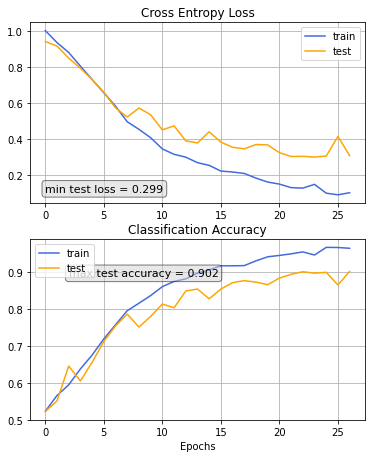

In [ ]:
model_name = "seq24"
summarize_diagnostics(history, model_name)
with open("{}_specs.txt".format(model_name),'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))

# To Do:
- Visualise data

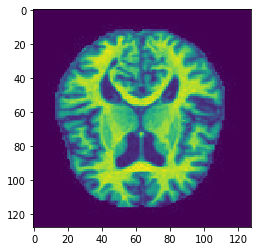

In [ ]:
plt.imshow(X[0], interpolation='nearest')